# TP Final Analisis de Datos Espaciales

## Clasificador campo / no campo

Al trabajar con datos del agro, es frecuente encontrarse con NAs en las variables `lat, lon`. Para resolver este inconveniente, se suele entrar a Google Maps, escribir la localidad y buscar algun campo a mano para sacar esta información. El problema claro es que este procedimiento **no es escalable** para un alto volumen de NAs, por lo tanto queremos investigar que soluciones alternativas existen.

Después de participar de las clases de ADE se nos ocurrió entrenar un clasificador binario campo / no campo que, dado un raster de imágenes satelitales, identifique satisfactoriamente las potenciales ubicaciones de donde sacar coordenadas. Esto podría solucionar nuestro problema, ahorrando muchisimo tiempo al proceso de analizar datos agro.

## Encontramos un paper

 [*"Automating field boundary delineation with multi-temporal Sentinel-2 imagery"*](https://www.researchgate.net/publication/337182705_Automating_field_boundary_delineation_with_multi-temporal_Sentinel-2_imagery)

 Usan técnicas de aprendizaje no supervisado que nos gustaría investigar (Canny Edge Detection, Watershed Segmentation) y comparar con un clasficiador supervisado por pixel. Los autores del paper sostienen que el análisis de imagen orientado a objetos (OBIA) supera limitaciones de las clasificaciones por pixel al **eliminar la necesidad de datos de entrenamiento y mejorar la precision espacial** al delinear limites de campo cerrados.

### Objetivo general

Nuestro objetivo general es diseñar y evaluar un método automático para detectar y delimitar áreas de campo agrícola a partir de imagenes multitemporales de Sentinel-2.

Queremos utilizar un método del paper que clasifica campos, no por píxel, sino por un conjunto de ellos que selecciona mediante el metodo canny y watershed segmentation.

* Canny ayuda a distiguir Bordes, zonas donde el valor cambia bruscamente → como el límite entre dos parcelas.

* Watershed crea regiones cerradas, posibles campos agrícolas.

Objetivos específicos

1. Construir una representación multi-temporal por píxel (características espectrales y fenológicas) a partir de series Sentinel-2.

2. Implementar un pipeline no supervisado de delineación de campos basado en detección de bordes (Canny) + Watershed (según paper) y extraer segmentos candidatos.

3. a) En este punto no sabemos si usar un modelo supervisado donde usamos datos secundarios para crear etiquetas automáticas débiles. Por ejemplo Zonas urbanas de OpenStreetMap → etiquetamos como “no campo”, extraer polígonos de áreas rurales por la pag oficial del gobierno IGN y/o eliminación automática de cuerpos de agua, infraestructura, ciudades.
  
     b) La otra opcion podria ser un modelo no supervisado, clustering. Donde se analiza cada cluster y se asigna etiqueta por interpretación visual o por porcentaje de presencia rural.



4. Evaluar la precisión de detección y la utilidad práctica para imputar coordenadas.

### Un poquito más detallado.

### Canny
* Suaviza la imagen (ruido ↓)

* Calcula gradiente de intensidad

* Detecta máximos de gradiente (posibles bordes)

* Aplica umbrales para quedarse con bordes significativos

* Conecta bordes en líneas limpias


### Watershed

Imagina la imagen como un mapa de alturas:

* Los valores bajos = valles (cuencas)

* Los valores altos = cimas

Luego:

* “Llenan de agua” los valles

* Cuando dos cuencas se encuentran → aparece una línea divisoria

* Esas líneas son segmentaciones (regiones)

una vez obtenida las regiones se extraen los segmentos candidatos que queremos (campo), para eso filtrariamos según criterios geompetricos o espectrales. (Área mínima:	Campos no suelen ser muy pequeños, por su forma	los lotes suelen tener formas regulares, por su NDVI medio alto: Vegetación presente y por su variabilidad temporal: Cultivos cambian a lo largo del tiempo.

## Rasters INTA

Descargamos RASTERS de la campaña agricola 23/24, hay un raster para invierno y otro para verano.


In [33]:
import numpy as np
import glob
import matplotlib.pyplot as plt
from skimage import feature, filters, segmentation, morphology
from scipy import ndimage as ndi
import os
import rasterio
import pandas as pd
r_rasters = r"..\data\raw\sentinel_23_24"


## Visualizaciones para comparar NDVI a lo largo del tiempo


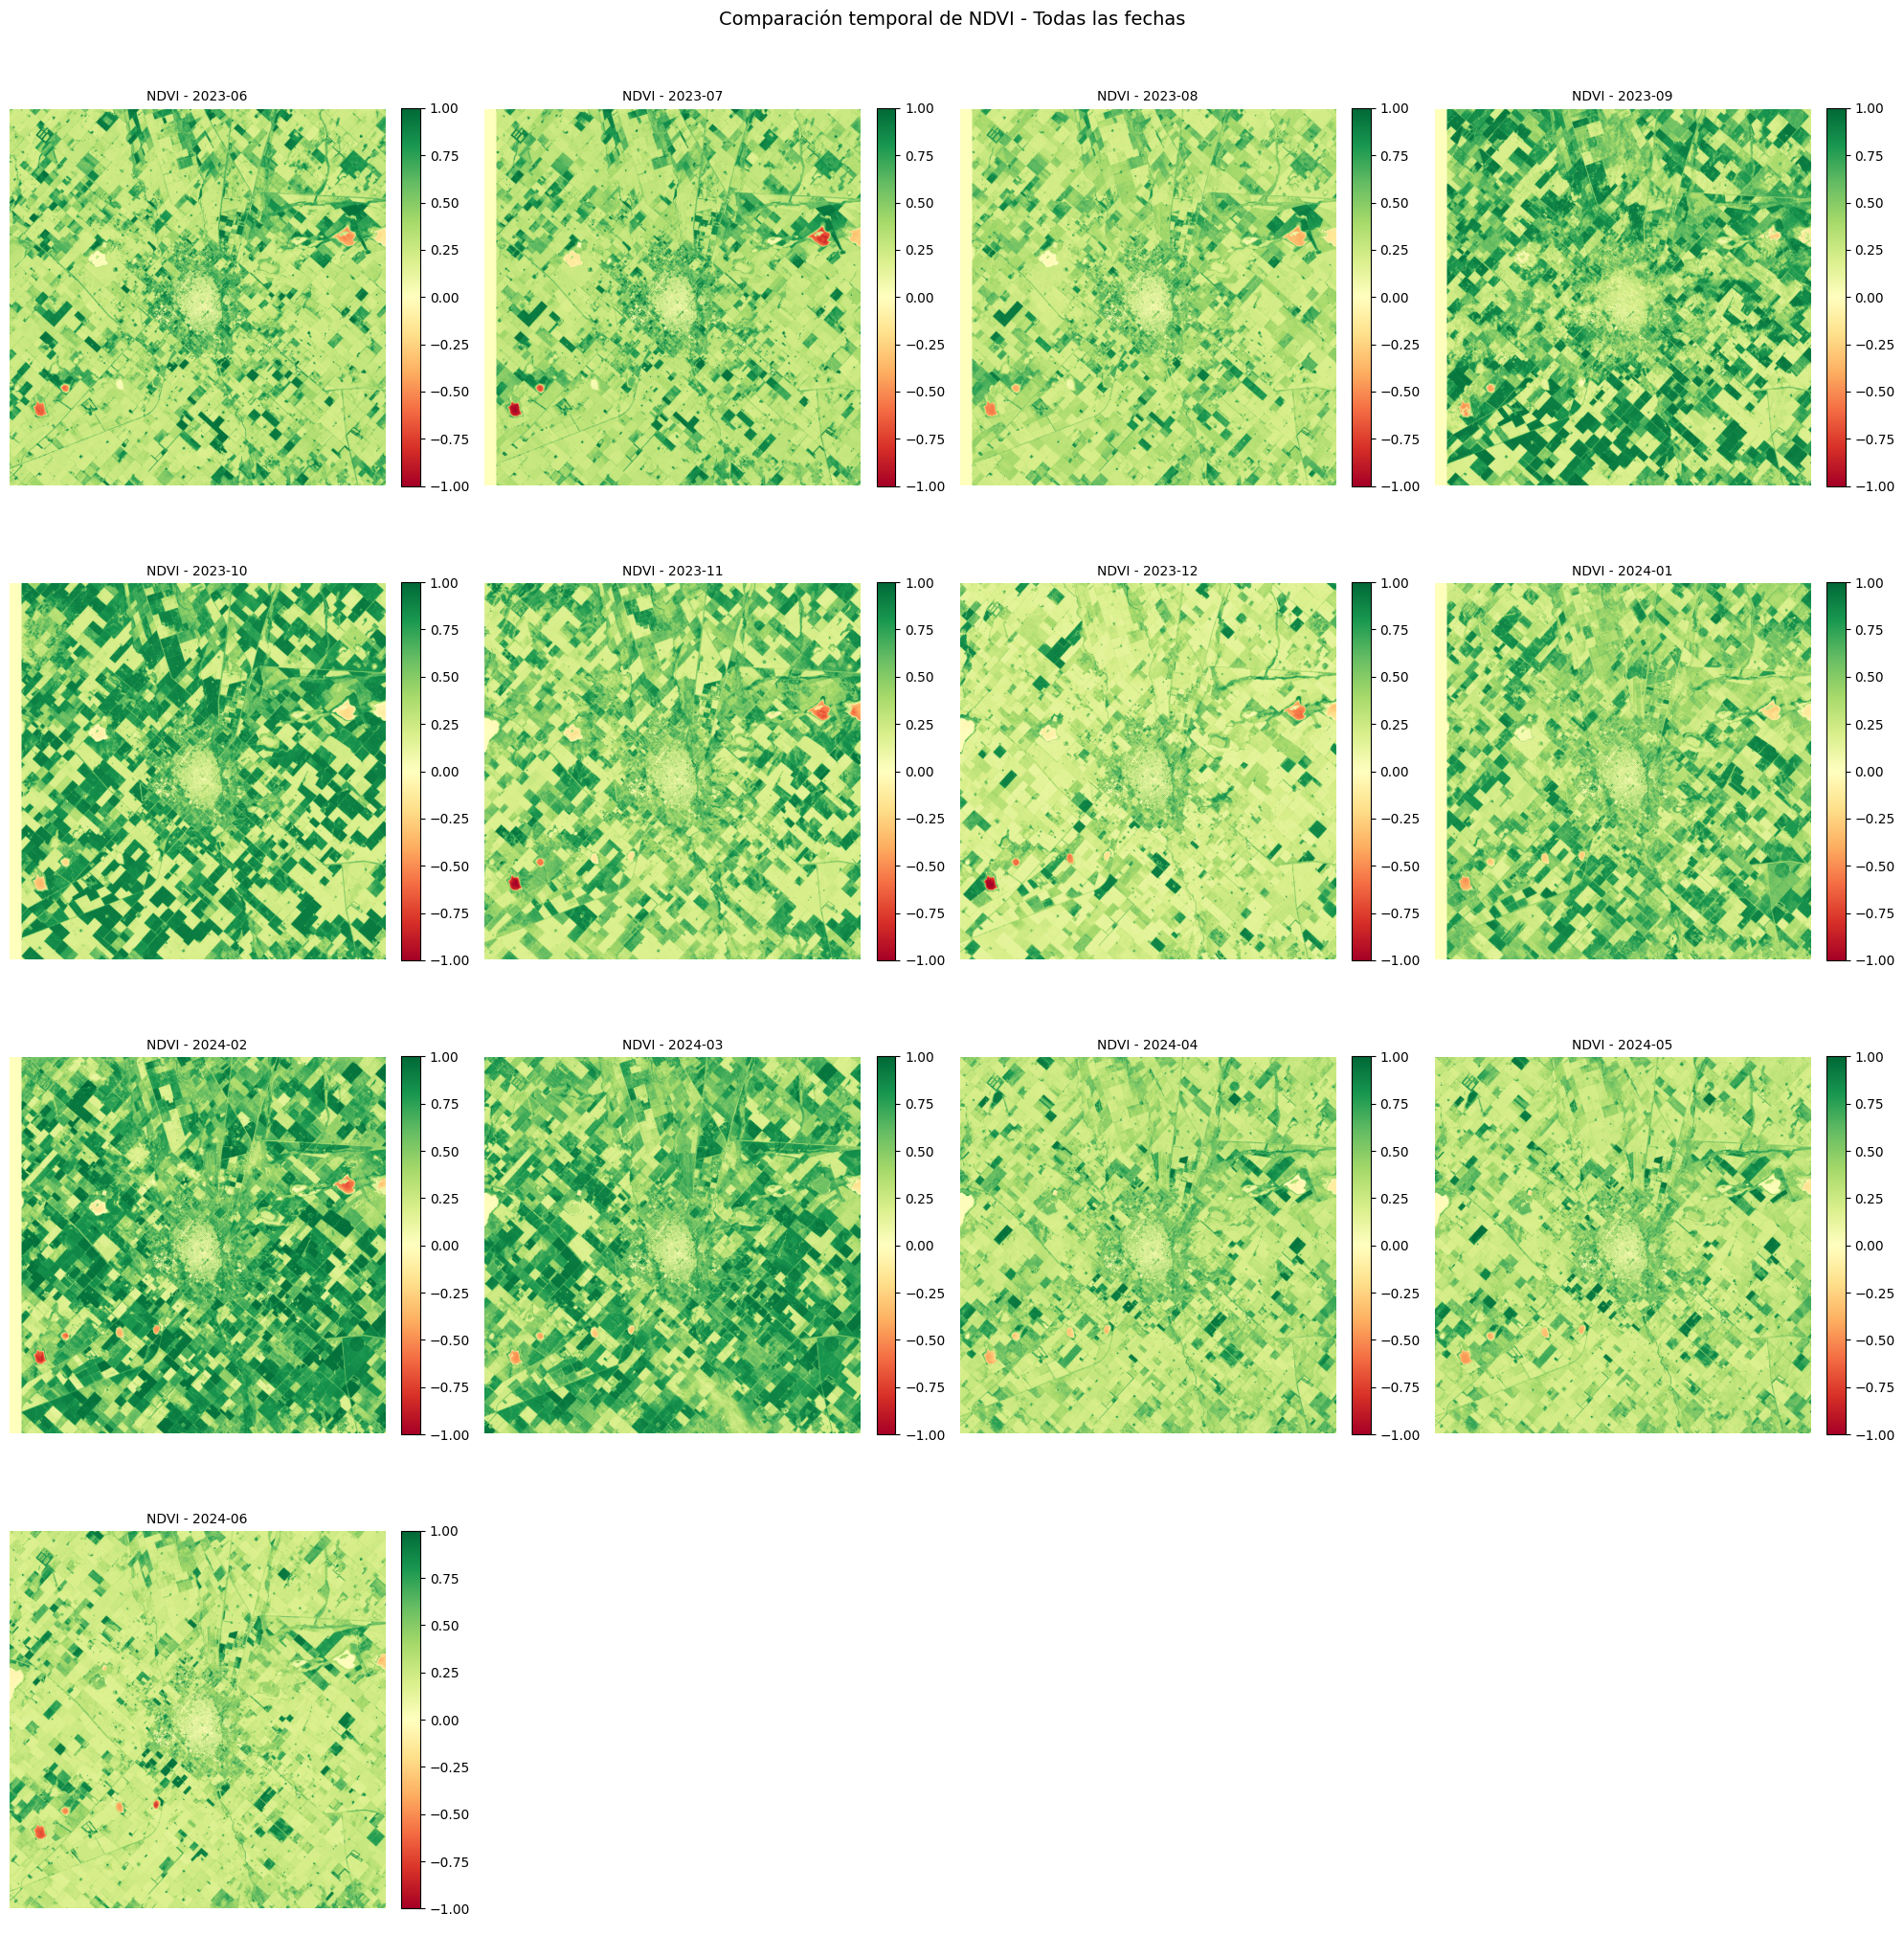

In [27]:
# VISUALIZACIÓN 1: Grid/Mosaico de todas las imágenes
# Permite comparar todas las fechas lado a lado

n_images = len(ndvi_imgs_mem)
n_cols = 4  # Ajustar según prefieras
n_rows = int(np.ceil(n_images / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
axes = axes.flatten() if n_images > 1 else [axes]

for i, (img, lbl) in enumerate(zip(ndvi_imgs_mem, ndvi_labels)):
    im = axes[i].imshow(img, cmap='RdYlGn', vmin=-1, vmax=1)
    axes[i].set_title(f"NDVI - {lbl}", fontsize=10)
    axes[i].axis('off')
    plt.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)

# Ocultar ejes vacíos
for i in range(n_images, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.suptitle("Comparación temporal de NDVI - Todas las fechas", y=1.02, fontsize=14)
plt.show()


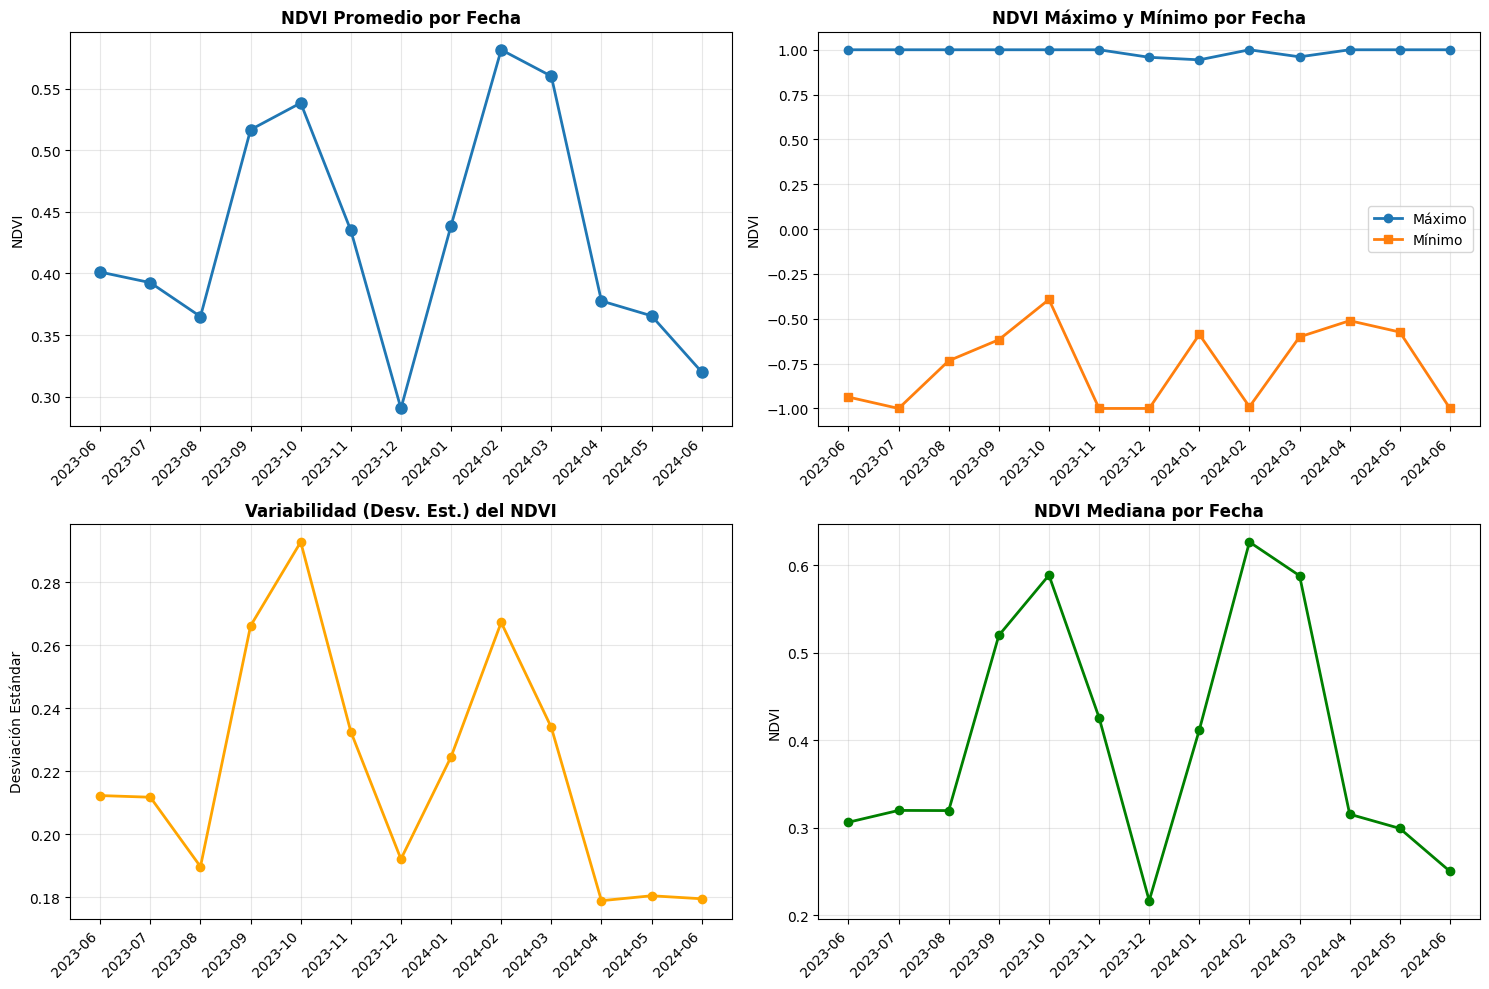


Estadísticas por fecha:
      Fecha  Promedio  Máximo  Mínimo  Desv. Est.  Mediana
0   2023-06    0.4011  1.0000 -0.9366      0.2123   0.3065
1   2023-07    0.3925  1.0000 -1.0000      0.2117   0.3200
2   2023-08    0.3650  1.0000 -0.7341      0.1897   0.3198
3   2023-09    0.5166  1.0000 -0.6167      0.2662   0.5199
4   2023-10    0.5383  1.0000 -0.3924      0.2928   0.5887
5   2023-11    0.4349  1.0000 -1.0000      0.2326   0.4260
6   2023-12    0.2905  0.9580 -1.0000      0.1921   0.2168
7   2024-01    0.4388  0.9439 -0.5874      0.2246   0.4119
8   2024-02    0.5814  1.0000 -0.9907      0.2673   0.6266
9   2024-03    0.5600  0.9606 -0.6010      0.2339   0.5881
10  2024-04    0.3777  1.0000 -0.5106      0.1789   0.3156
11  2024-05    0.3656  1.0000 -0.5741      0.1804   0.2994
12  2024-06    0.3201  1.0000 -1.0000      0.1795   0.2504


In [35]:
# VISUALIZACIÓN 3: Estadísticas temporales
# Muestra estadísticas agregadas (promedio, máximo, mínimo, desviación estándar) por fecha

stats = {
    'Fecha': ndvi_labels,
    'Promedio': [np.nanmean(img) for img in ndvi_imgs_mem],
    'Máximo': [np.nanmax(img) for img in ndvi_imgs_mem],
    'Mínimo': [np.nanmin(img) for img in ndvi_imgs_mem],
    'Desv. Est.': [np.nanstd(img) for img in ndvi_imgs_mem],
    'Mediana': [np.nanmedian(img) for img in ndvi_imgs_mem]
}

df_stats = pd.DataFrame(stats)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Promedio temporal
axes[0, 0].plot(range(len(df_stats)), df_stats['Promedio'], marker='o', linewidth=2, markersize=8)
axes[0, 0].set_xticks(range(len(df_stats)))
axes[0, 0].set_xticklabels(df_stats['Fecha'], rotation=45, ha='right')
axes[0, 0].set_title('NDVI Promedio por Fecha', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('NDVI')
axes[0, 0].grid(True, alpha=0.3)

# Máximo y Mínimo
axes[0, 1].plot(range(len(df_stats)), df_stats['Máximo'], marker='o', label='Máximo', linewidth=2)
axes[0, 1].plot(range(len(df_stats)), df_stats['Mínimo'], marker='s', label='Mínimo', linewidth=2)
axes[0, 1].set_xticks(range(len(df_stats)))
axes[0, 1].set_xticklabels(df_stats['Fecha'], rotation=45, ha='right')
axes[0, 1].set_title('NDVI Máximo y Mínimo por Fecha', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('NDVI')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Desviación estándar (variabilidad)
axes[1, 0].plot(range(len(df_stats)), df_stats['Desv. Est.'], marker='o', color='orange', linewidth=2)
axes[1, 0].set_xticks(range(len(df_stats)))
axes[1, 0].set_xticklabels(df_stats['Fecha'], rotation=45, ha='right')
axes[1, 0].set_title('Variabilidad (Desv. Est.) del NDVI', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Desviación Estándar')
axes[1, 0].grid(True, alpha=0.3)

# Mediana
axes[1, 1].plot(range(len(df_stats)), df_stats['Mediana'], marker='o', color='green', linewidth=2)
axes[1, 1].set_xticks(range(len(df_stats)))
axes[1, 1].set_xticklabels(df_stats['Fecha'], rotation=45, ha='right')
axes[1, 1].set_title('NDVI Mediana por Fecha', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('NDVI')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Mostrar tabla de estadísticas
print("\nEstadísticas por fecha:")
print(df_stats.round(4))


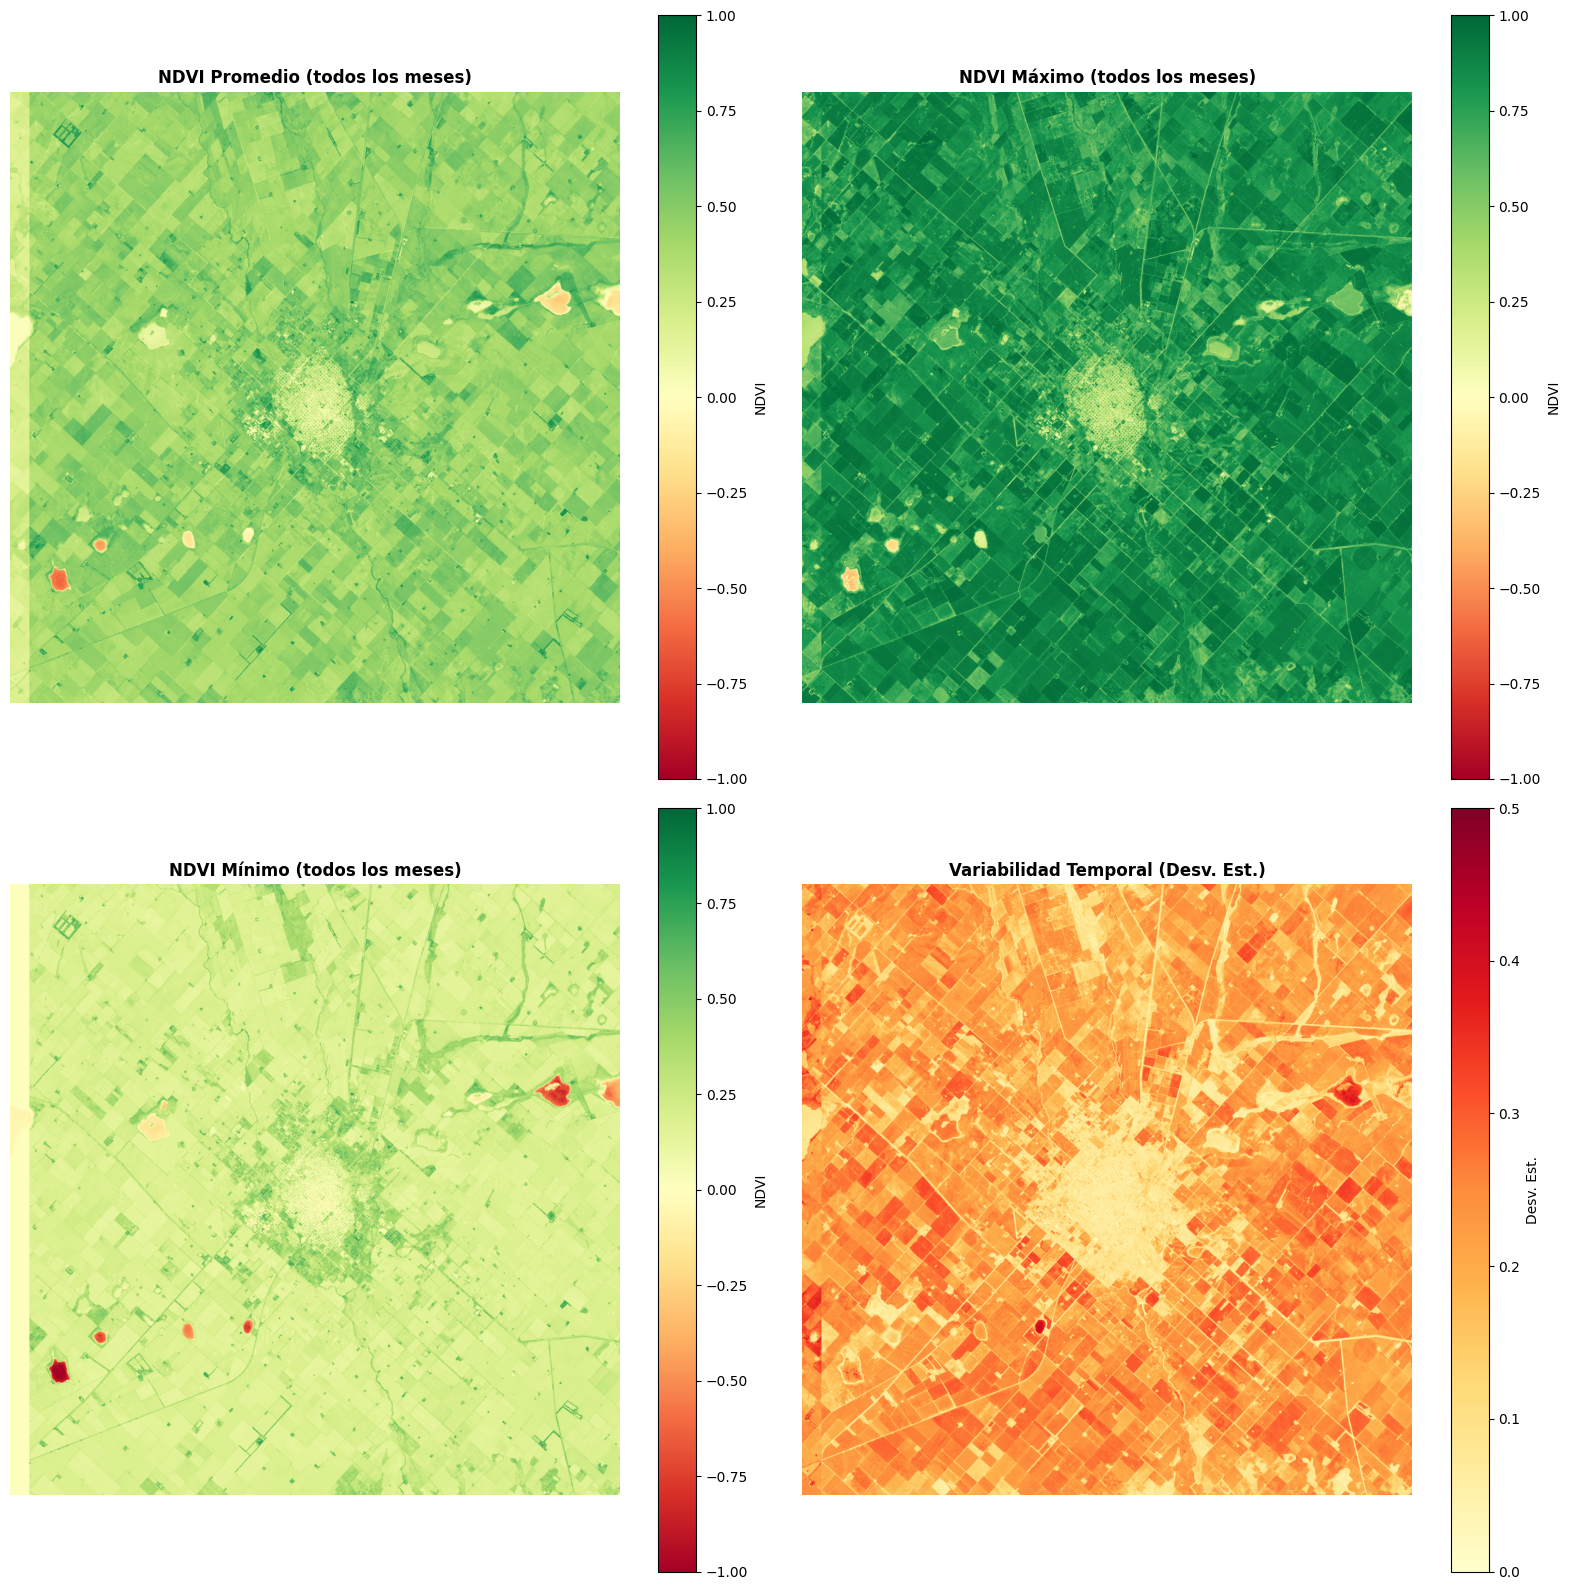

In [38]:
# VISUALIZACIÓN 6: Mapas de estadísticas temporales
# Muestra el promedio, máximo, mínimo y variabilidad a lo largo del tiempo por píxel

# Calcular estadísticas por píxel a lo largo del tiempo
ndvi_stack = np.stack(ndvi_imgs_mem, axis=0)  # Shape: (tiempo, altura, ancho)

ndvi_mean = np.nanmean(ndvi_stack, axis=0)
ndvi_max = np.nanmax(ndvi_stack, axis=0)
ndvi_min = np.nanmin(ndvi_stack, axis=0)
ndvi_std = np.nanstd(ndvi_stack, axis=0)

fig, axes = plt.subplots(2, 2, figsize=(16, 16))

# Promedio temporal
im1 = axes[0, 0].imshow(ndvi_mean, cmap='RdYlGn', vmin=-1, vmax=1)
axes[0, 0].set_title('NDVI Promedio (todos los meses)', fontsize=12, fontweight='bold')
axes[0, 0].axis('off')
plt.colorbar(im1, ax=axes[0, 0], label="NDVI")

# Máximo temporal
im2 = axes[0, 1].imshow(ndvi_max, cmap='RdYlGn', vmin=-1, vmax=1)
axes[0, 1].set_title('NDVI Máximo (todos los meses)', fontsize=12, fontweight='bold')
axes[0, 1].axis('off')
plt.colorbar(im2, ax=axes[0, 1], label="NDVI")

# Mínimo temporal
im3 = axes[1, 0].imshow(ndvi_min, cmap='RdYlGn', vmin=-1, vmax=1)
axes[1, 0].set_title('NDVI Mínimo (todos los meses)', fontsize=12, fontweight='bold')
axes[1, 0].axis('off')
plt.colorbar(im3, ax=axes[1, 0], label="NDVI")

# Variabilidad temporal (desviación estándar)
im4 = axes[1, 1].imshow(ndvi_std, cmap='YlOrRd', vmin=0, vmax=0.5)
axes[1, 1].set_title('Variabilidad Temporal (Desv. Est.)', fontsize=12, fontweight='bold')
axes[1, 1].axis('off')
plt.colorbar(im4, ax=axes[1, 1], label="Desv. Est.")

plt.tight_layout()
plt.show()
